In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import pandas as pd

model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xl").to("cuda")
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xl")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
def preprocess(dataset):
    dataset.rename(columns={'sentiment': 'Sentiment', 'review': 'Text'}, inplace=True)
    dataset['Sentiment'] = dataset['Sentiment'].replace({'negative': 0, 'positive': 1})
    dataset['Sentiment'] = dataset['Sentiment'].replace({'Negative': 0, 'Positive': 1})
    # dataset = dataset.sample(frac=1, random_state=1).reset_index(drop=True)


In [3]:
start = 0
end = 500
answers = end - start

In [4]:
imdb = pd.read_csv("IMDB Dataset.csv")
preprocess(imdb)

imdb = imdb[start:end]

/tmp/ipykernel_13733/1541051826.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['Sentiment'] = dataset['Sentiment'].replace({'negative': 0, 'positive': 1})


In [5]:
def inference(*, prompt, sentence, tokenizer, model):
    inputs_ids = tokenizer(prompt(sentence),  padding='max_length', return_tensors="pt").input_ids.to("cuda")
    outputs = model.generate(inputs_ids, max_new_tokens=50)
    result = tokenizer.decode(outputs[0], skip_special_tokens=True)

    
    if "negative" in result.lower():
        return 0
    elif "positive" in result.lower():
        return 1
    else:
        return 2

In [8]:
import random


def build_example(dataset, index):
    return ("Text: " + dataset.Text[index] + "\nSentiment: " + ["negative","positive"][dataset.Sentiment[index]] + "\n\n")

def get_build_prompt(dataset, index, shots, system):
    def build_prompt(sent):
        ret = ""
        if(system):
            if(shots > 0):
                ret += "Classify the text into negative or positive. Here you have some examples:\n\n"
            else:
                ret += "Classify the text into negative or positive.\n\n"
        help_list = []
        for j in range(shots):
            help = random.sample(range(len(dataset)), 1)[0]
            while(index == help or help in help_list):
                help = random.sample(range(len(dataset)), 1)[0]
            help_list.append(help)
            example = build_example(dataset, help)
            ret += example
        ret += "Text: " + sent + "\nSentiment: "
        return ret
    return build_prompt


In [11]:
import random
from sklearn.metrics import classification_report
import torch
from tqdm import tqdm


@torch.no_grad()
def eval(dataset, system):
    overall_results = dict()

    for shots in [0,1,2]:
        if(shots == 0):
             test = 1
        else:
            test = 1
        print("Running shot", shots)
        for run in range(test):
            print("Run", run)
            targets = []
            predictions = []
            total = len(dataset)
            
            for i in tqdm(range(total), total=total):
                prompt = get_build_prompt(dataset, i, shots, system)
                targets.append(dataset.Sentiment[i])
                predictions.append(inference(prompt=prompt, sentence=dataset.Text[i], tokenizer=tokenizer, model=model))
            
            right, wrong, no_sentiment = 0, 0, 0
            
            for j in range(len(predictions)):
                if(predictions[j] == 2):
                    no_sentiment += 1
                elif(targets[j] == predictions[j]):
                        right += 1
                elif(targets[j] != predictions[j]):
                        wrong += 1

            if shots not in overall_results:
                overall_results[shots] = dict()

            overall_results[shots] = {'correct' : right/len(predictions), 'wrong' : wrong/len(predictions), 'no_sentiment': no_sentiment/len(predictions)}
            # report = classification_report(targets, predictions, labels=[0,1,2], output_dict=True, zero_division=0)
            # overall_results[shots] = report

    return overall_results

In [12]:
import json
import csv

def write_csv(file_path, dataframe):
    csv_path = "csv/" + file_path + ".csv"
    json_path = "json/" + file_path + ".json"
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Scrittura dell'intestazione
        writer.writerow(['', '', file_path.replace("_results", ""), ''])
        writer.writerow(['', '', 'Errors', '', '', 'Errors', '', '', 'Errors', '', '', 'Errors'])
        writer.writerow(['Runs', 'Correct', 'Wrong', 'No_sentiment', 'Correct', 'Wrong', 'No_sentiment', 'Correct', 'Wrong', 'No_sentiment', 'Correct', 'Wrong', 'No_sentiment'])
        
        # Scrittura dei dati
        for j in range(3):
            field = ["Run " + str(j)]
            if(j != 0):
                field.append("")
                field.append("")
                field.append("")
            for shots, runs in dataframe.items():
                for run_number, metrics in runs.items():
                    if(run_number == j):
                        field.append(metrics['correct'])
                        field.append(metrics['wrong'])
                        field.append(metrics['no_sentiment'])
            writer.writerow(field)
    print(f"I dati sono stati scritti su {csv_path}.")

    with open(json_path, 'w') as f:
        json.dump(dataframe, f, sort_keys=True, indent=4)

NameError: name 'spaced' is not defined

In [13]:
no_caps = eval(dataset=imdb, system=False)

# file = ''

# write_csv(file, imdb)
# # Scrittura dei dati su un file CSV

Running shot 0
Run 0


100%|██████████| 500/500 [02:13<00:00,  3.76it/s]


Running shot 1
Run 0


100%|██████████| 500/500 [03:17<00:00,  2.54it/s]


Running shot 2
Run 0


100%|██████████| 500/500 [05:10<00:00,  1.61it/s]


In [14]:
with open("json/no_caps.json", 'w') as f:
        json.dump(no_caps, f, sort_keys=True, indent=4)

In [12]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

accuracy = dict()

def add_accuracy(data, name):
    for shot, metrics in data.items():
        if shot not in accuracy:
            accuracy[shot] = dict()
        total = 0
        accuracy[shot]['name'] = metrics['correct']


In [13]:
add_accuracy(no_caps, 'no_caps')

In [ ]:
accuracy

In [20]:
indices = list(accuracy.keys())

# Estrai tutti i valori per 'SP_original', 'SP_contrast', 'original', 'contrast'
SP_original_values = [accuracy[i]['SP_original'] for i in indices]

# Larghezza delle barre
bar_width = 0.2

# Posizioni per gli indici
index = np.arange(len(indices))

# Crea il plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.ylim(0.94, 0.97)
bar1 = ax.bar(index - bar_width, SP_original_values, bar_width, label='SP_original')
bar2 = ax.bar(index, SP_contrast_values, bar_width, label='SP_contrast')
bar3 = ax.bar(index + bar_width, original_values, bar_width, label='original')
bar4 = ax.bar(index + 2*bar_width, contrast_values, bar_width, label='contrast')

# Etichette, titoli e legenda
ax.set_xlabel('Index')
ax.set_ylabel('Values')
ax.set_title('Comparison of Values')
ax.set_xticks(index)
ax.set_xticklabels(indices)
ax.legend()

plt.tight_layout()
plt.show()

KeyError: 'SP_original'

In [5]:
# import json
# with open("json/SP_original_results.json", "r") as file:
#     SP_results_original_set = json.load(file)

# with open("json/SP_contrast_results.json", "r") as file:
#     SP_results_contrast_set = json.load(file)

# with open("json/original_results.json", "r") as file:
#     results_original_set = json.load(file)

# with open("json/contrast_results.json", "r") as file:
#     results_contrast_set = json.load(file)

In [14]:
from matplotlib import pyplot as plt
import numpy as np

def plot_dataframe(data, title):
    # Estrazione dei dati
    shots = list(data.keys())
    correct_values = [data[shot]['correct'] for shot in shots]
    wrong_values = [data[shot]['wrong'] for shot in shots]
    no_sentiment_values = [data[shot]['no_sentiment'] for shot in shots]

    # Larghezza delle barre
    bar_width = 0.25

    # Posizioni delle barre
    r1 = np.arange(len(shots))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Creazione del plot
    fig, ax = plt.subplots(figsize=(12, 6))

    bars1 = ax.bar(r1, correct_values, color='b', width=bar_width, edgecolor='grey', label='Correct')
    bars2 = ax.bar(r2, wrong_values, color='r', width=bar_width, edgecolor='grey', label='Wrong')
    bars3 = ax.bar(r3, no_sentiment_values, color='g', width=bar_width, edgecolor='grey', label='No Sentiment')

    # Aggiunta delle etichette e del titolo
    ax.set_xlabel('Number of Helps', fontweight='bold')
    ax.set_ylabel('Values', fontweight='bold')
    ax.set_title(title, fontweight='bold')
    ax.set_xticks([r + bar_width for r in range(len(shots))])
    ax.set_xticklabels(shots)
    ax.legend()

    # Aggiunta dei valori delle barre con precisione a 3 cifre decimali
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.3f}', ha='center', va='bottom')

    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.3f}', ha='center', va='bottom')

    for bar in bars3:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.3f}', ha='center', va='bottom')

    # Mostra il plot
    plt.show()

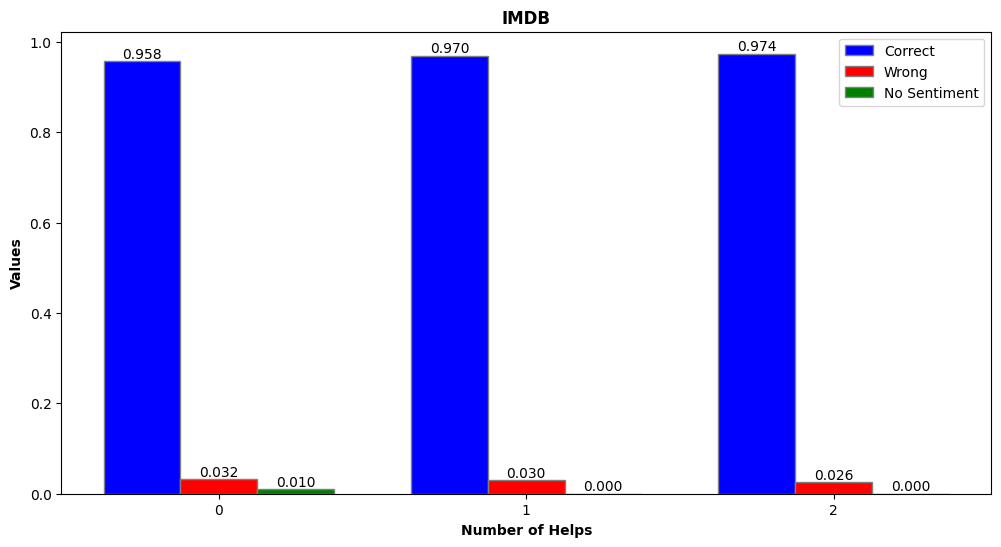

In [15]:
plot_dataframe(no_caps, "no_caps")


In [ ]:
total = []
indexes = []
original_result = [accuracy[x]['accuracy'] for x in range(len(performance_original))]
contrast_result = [performance_contrast[x]['accuracy'] for x in range(len(performance_contrast))]
shots_list = [str(x)+' Shots' for x in [y['shot'] for y in performance_original]]

for i in range(len(original_result)):
    total.append(original_result[i])
    total.append(contrast_result[i])
    indexes.append(shots_list[i])
    indexes.append(shots_list[i]+' C')

print(total)
print(indexes)

In [ ]:
plt.bar([i for i in range(len(indexes)) if i % 2 == 0], [total[i] for i in range(len(indexes)) if i % 2 == 0], color='blue', label='Original')
plt.bar([i for i in range(len(indexes)) if i % 2 != 0], [total[i] for i in range(len(indexes)) if i % 2 != 0], color='red', label='Adversarial')
plt.xticks(ticks = [i for i in range(len(indexes))], labels=[indexes[i] for i in range(len(indexes))], fontsize=6)

plt.ylabel('Accuracy')
plt.xlabel('Shots')

plt.title('Accuracy on different Few Shots Situations')
plt.legend()
plt.show()

In [ ]:
plt.bar(range(len(original_result)), original_result)
plt.xticks(ticks = [])
plt.ylabel('Accuracy')
plt.xlabel('Shots')

plt.title('Accuracy on different Few Shots Situations')
plt.legend()
plt.show()